In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import r2_score
import pickle
import time
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy import sparse
import os.path
from scipy.interpolate import splrep, splev
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
sys.path.append('../..')
from CIMatrixLib.src.util import *
from CIMatrixLib.src.TreatPattern import *
from CIMatrixLib.src.algorithms.DebiasConvex import *
from CIMatrixLib.src.algorithms.CovariancePCA import *
from CIMatrixLib.src.algorithms.MCNNM import *
from CIMatrixLib.src.algorithms.RobustSyntheticControl import *
import CIMatrixLib.src.readData as readData
from CIMatrixLib.src.algorithms.OLS import *
import importlib

sns.set_style("whitegrid")

In [59]:
r =  2
n1 = 100
n2 = 100
array_WPCA = []
array_d = []
array_test = []
array_M = []

location_array = [-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3]

for T, loc in enumerate(location_array):
    array_WPCA.append([])
    array_d.append([])
    for i in range (100):
        #U = np.random.gamma(shape = 1, scale = 2, size = (n1, r))
        #V = np.random.gamma(shape = 1, scale = 2, size = (n2, r))
        #M0 = U.dot(V.T)
        U = np.random.normal(loc = loc, scale = 1, size = (n1, r))
        V = np.random.normal(loc = abs(loc), scale = 1, size = (n1, r))
        #E = np.random.normal(loc=0, scale = 1, size = (n1, n2))
        M0 = U.dot(V.T)
        
        E = np.random.normal(loc=0, scale = 0.1, size = (n1, n2))
        u_M0, s, v_M0h = np.linalg.svd(M0, full_matrices=False)
        u_M0 = u_M0[:, :r]
        #print(np.mean(M0))
        #print(U.T.dot(U))

        #print(s[:2]**2 / M0.shape[1])

        
        Z = np.zeros((n1, n2))
        Z[:1, int(n1/2):] = 1
        #Z[1,1] = 1
        tau_star = 1

        O = M0 + E + tau_star * Z

        # O_ob = M0 * (1-Z)
        # #print((M0.dot(M0))[0,:] / M0.shape[1]-(O_ob.dot(O_ob) / (1-Z).dot(1-Z))[0,:])
        # G = (M0.dot(M0.T)) / M0.shape[1]-(O_ob.dot(O_ob.T) / (1-Z).dot((1-Z).T))
        # #print(G)
        # s_G = np.linalg.svd(G, full_matrices=False, compute_uv=False)
        # u_O, s_O, v_Oh = np.linalg.svd((O_ob.dot(O_ob.T) / (1-Z).dot((1-Z).T)), full_matrices=False)
        # u_O = u_O[:, :r]
        #print('s_O:', s_O[:2])
        #print('s_G:', s_G[:2])
        #array_test.append((M0.dot(M0))[0,1] / M0.shape[1] - (O_ob.dot(O_ob) / (1-Z).dot(1-Z))[0,1])

        M, tau, u = covariance_PCA(O, 1-Z, suggest_r=r, return_U = True)
        #print((u.dot(u.T) - u_M0.dot(u_M0.T))[0, 1])
        M_d, tau_d, M_no, tau_no = tune_convex_algorithm_with_rank(O, Z, suggest_r = r, suggest_lambda=s[r-1]/1.1, real_data = False,  de_mean_O=False)
        #tau_d = 0
        #if (np.linalg.norm(u/np.sqrt(n1) - U / l) > 1):
        #    u = -u
        #u, s, vh = np.linalg.svd(M, full_matrices=False)
        #array.append(u[0,0] - U[0,0])
        #print('test')
        #print(u_M0.dot(u_M0.T)[1,:])
        #print((u.dot(u.T)/M0.shape[0])[1, :])
        #print((u.dot(u.T)/M0.shape[0] - u_M0.dot(u_M0.T))[0,:])
        #print(M[0, 0] - M0[0, 0])
        #print((u.dot(u.T)/M0.shape[0])[0,:])
        #print(u_M0.dot(u_M0.T)[0,:])
        #print((u.dot(u.T)/(M0.shape[0]-1)).dot(O_ob)[0,51], M0[0, 51])
        #array_test.append((u.dot(u.T)/(M0.shape[0])).dot(O_ob)[0,55] - M0[0, 55])
        #print('u_O[0,0]', u_O.dot(u_O.T)[0,0])
        #print('u_M0[0,0]', u_M0.dot(u_M0.T)[0, 0])
        #print((u.dot(u.T)/M0.shape[0] - u_M0.dot(u_M0.T))[0, 0])
        #array_test.append((u.dot(u.T)/M0.shape[0] - u_M0.dot(u_M0.T))[0, 0])
        #array_M.append(M[0,55] - M0[0, 55])
        array_WPCA[T].append(tau-tau_star)
        array_d[T].append(tau_d - tau_star)
        # Ω = 1 - Z
        # A = O.dot(O.T) / Ω.dot(Ω.T)
        # u,s,vh = np.linalg.svd(A, full_matrices=False)

        #print(s[0])
    print(np.std(array_WPCA[T]), np.mean(array_WPCA[T]))
    print(np.std(array_d[T]), np.mean(array_d[T]))

1.6370127463682438 -0.9425537333420497
0.018733328995539037 0.002371225790611573
0.6181052210445027 -0.1980234809929999
0.017711969119009463 -0.0012155245179486585
0.26028888708153153 -0.0648110836015561
0.018970034809122457 0.0012720443072396148
0.17110136252584196 -0.04061090421948328
0.015415252821238552 0.0018838071826588155
0.03289129629465345 0.0008237009710696752
0.014653445767359358 -3.789031560775258e-05
0.10452860062250864 0.003744480949139537
0.015047091812715312 0.003293414656908966
0.28971418210454797 0.10838213777990713
0.01800343931326313 0.004677764287039422
0.6198687892200586 0.23382960003886688
0.01855987828927167 -0.0008832134163737515
1.3900406904348572 0.967364286417539
0.020737251893697007 -0.0015598611608788494


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
-3
1.6370127463682438 -0.9425537333420497
0.018733328995539037 0.002371225790611573
-2
0.6181052210445027 -0.1980234809929999
0.017711969119009463 -0.0012155245179486585
-1
0.26028888708153153 -0.0648110836015561
0.018970034809122457 0.0012720443072396148
-0.5
0.17110136252584196 -0.04061090421948328
0.015415252821238552 0.0018838071826588155
0
0.03289129629465345 0.0008237009710696752
0.014653445767359358 -3.789031560775258e-05
0.5
0.10452860062250864 0.003744480949139537
0.015047091812715312 0.003293414656908966
1
0.28971418210454797 0.10838213777990713
0.01800343931326313 0.004677764287039422
2
0.6198687892200586 0.23382960003886688
0.01855987828927167 -0.0008832134163737515
3
1.3900406904348572 0.967364286417539
0.020737251893697007 -0.0015598611608788494


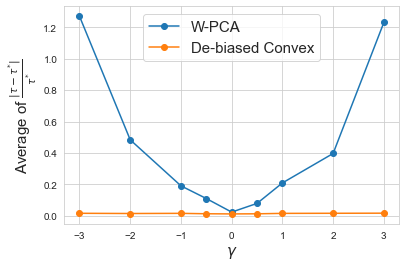

In [65]:
WPCA = []
DC = []
WPCA_std = []
DC_std = []
for T, loc in enumerate(location_array):
    print(loc)
    print(np.std(array_WPCA[T]), np.mean(array_WPCA[T]))
    print(np.std(array_d[T]), np.mean(array_d[T]))
    WPCA.append(np.mean(np.abs(array_WPCA[T])))
    WPCA_std.append(np.std(np.abs(array_WPCA[T])))
    DC.append(np.mean(np.abs(array_d[T])))
    DC_std.append(np.std(np.abs(array_d[T])))
plt.plot(location_array, WPCA, '-o', label = 'W-PCA')
plt.plot(location_array, DC, '-o', label = 'De-biased Convex')
plt.legend(fontsize = 15)
plt.xlabel(r'$\gamma$', fontsize = 15)
plt.ylabel(r'Average of $\frac{|\tau-\tau^{*}|}{\tau^{*}}$', fontsize = 15)
plt.savefig('results/plot_results/W-PCA_non_zero_mean.eps')
plt.show()

0.007312620639011316
-0.32239457927362386


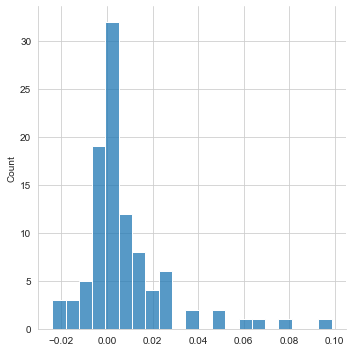

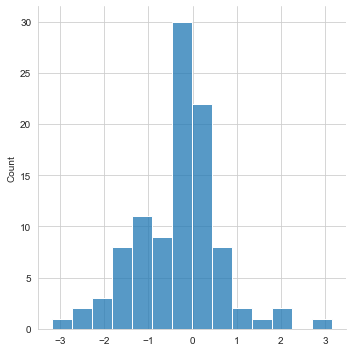

In [29]:
sns.displot(array_test)
print(np.mean(array_test))
sns.displot(array_M)
print(np.mean(array_M))

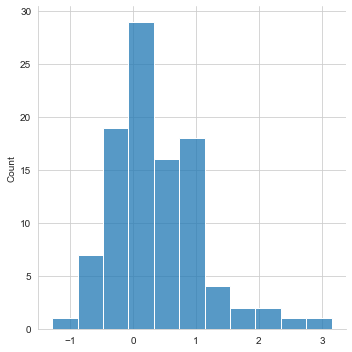

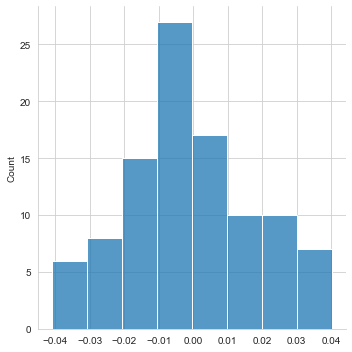

In [30]:
sns.displot(array)

sns.displot(array_d)

In [31]:
print(np.std(array), np.mean(array))
print(np.std(array_d), np.mean(array_d))

0.7184473251653205 0.3602439380051304
0.01887289051486731 -0.0012462597949761368


In [56]:
print(np.sqrt(2)/np.sqrt(100))

0.1414213562373095
